<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Include-photometry-with-Grizli-grism-fits" data-toc-modified-id="Include-photometry-with-Grizli-grism-fits-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Include photometry with Grizli grism fits</a></span></li><li><span><a href="#Scaling-the-spectrum-to-the-photometry" data-toc-modified-id="Scaling-the-spectrum-to-the-photometry-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scaling the spectrum to the photometry</a></span></li><li><span><a href="#Redshift-PDF" data-toc-modified-id="Redshift-PDF-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Redshift PDF</a></span></li><li><span><a href="#Grizli-internal-photometry" data-toc-modified-id="Grizli-internal-photometry-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Grizli internal photometry</a></span></li><li><span><a href="#Compare-chi-squared" data-toc-modified-id="Compare-chi-squared-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compare chi-squared</a></span></li></ul></div>

### Include photometry with Grizli grism fits ###

`grizli` has the ability to include constraints from broad-band photometry in the redshift fitting.  Using this capability requires some of the tools provided by the `eazy-py` module (https://github.com/gbrammer/eazy-py).

The example below is intended to be run in the same directory where you've already run the [Grizli-Pipeline](https://github.com/gbrammer/grizli/blob/master/examples/Grizli-Pipeline.ipynb) notebook to process the GOODS-South ERS grism data.  

Here we take photometry from the 3D-HST photometric catalog (Skelton et al.) of the GOODS-South field.  The 3D-HST products are available at https://archive.stsci.edu/prepds/3d-hst/.

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import drizzlepac

import grizli
from grizli.pipeline import photoz
from grizli import utils, prep, multifit, fitting



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


In [3]:
utils.set_warnings()
print('\n Grizli version: ', grizli.__version__)

# Requires eazy-py:  https://github.com/gbrammer/eazy-py
import eazy
print('\n Eazy-py version: ', eazy.__version__)


 Grizli version:  1.2.dev120

 Eazy-py version:  0.4.dev80


In [4]:
# Run in the directory where you ran the Grizli-Pipeline notebook and 
# extracted spectra of two objects
root = 'j033216m2743'
os.chdir('{0}/Extractions/'.format(root))

In [5]:
# Fetch 3D-HST catalogs
if not os.path.exists('goodss_3dhst.v4.1.cats.tar.gz'):
    os.system('wget https://archive.stsci.edu/missions/hlsp/3d-hst/RELEASE_V4.0/Photometry/GOODS-S/goodss_3dhst.v4.1.cats.tar.gz')
    os.system('tar xzvf goodss_3dhst.v4.1.cats.tar.gz')

In [6]:
# Preparation for eazy-py
eazy.symlink_eazy_inputs()

/Users/gbrammer/miniconda3/envs/grizli37/lib/python3.7/site-packages/eazy/data/templates -> ./templates
/Users/gbrammer/miniconda3/envs/grizli37/lib/python3.7/site-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest


In [7]:
### Initialize **eazy.photoz** object
field = 'goodss'
version = 'v4.1'

params = {}
params['CATALOG_FILE'] = '{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format(field, version)
params['Z_STEP'] = 0.002
params['Z_MAX'] = 10

params['MAIN_OUTPUT_FILE'] = '{0}_3dhst.{1}.eazypy'.format(field, version)
params['PRIOR_FILTER'] = 205

# Galactic extinction
params['MW_EBV'] = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 
                    'uds':0.0195, 'goodsn':0.0103}[field]

params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'

translate_file = '{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.translate'.format(field, version)

ez = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_file, 
                        zeropoint_file=None, params=params, 
                        load_prior=True, load_products=False)

Read default param file: /Users/gbrammer/miniconda3/envs/grizli37/lib/python3.7/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat
   >>> NOBJ = 50507
f_F160W e_F160W (205): hst/wfc3/IR/f160w.dat
f_U e_U (103): ESO/vimos_u.res
f_F435W e_F435W (  1): hst/ACS_update_sep07/wfc_f435w_t77.dat
f_F606Wcand e_F606Wcand (236): hst/ACS_update_sep07/wfc_f606w_t81.dat
f_F606W e_F606W (  4): hst/ACS_update_sep07/wfc_f606w_t77.dat
f_R e_R (260): ESO/VIMOS/R.dat
f_F775W e_F775W (  5): hst/ACS_update_sep07/wfc_f775w_t77.dat
f_F814Wcand e_F814Wcand (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
f_F850LP e_F850LP (  7): hst/ACS_update_sep07/wfc_f850lp_t77.dat
f_F850LPcand e_F850LPcand (240): hst/ACS_update_sep07/wfc_f850lp_t81.dat
f_F125W e_F125W (203): hst/wfc3/IR/f125w.dat
f_J e_J ( 34): ESO/isaac_j.res
f_F140W e_F140W (204): hst/wfc3/IR/f140w.dat
f_H e_H ( 36): ESO/isaac_h.res
f_Ks e_Ks ( 37): ESO/isaac_ks.res
f_IRAC1 e_IRAC1 ( 18): IRAC

In [8]:
## Grism fitting arguments created in Grizli-Pipeline
args = np.load('fit_args.npy', allow_pickle=True)[0]

## First-pass redshift templates, similar to the eazy templates but 
## with separate emission lines
t0 = args['t0']

#############
## Make a helper object for generating photometry in a format that grizli 
## understands. 

## Passing the parameters precomputes a function to quickly interpolate
## the templates through the broad-band filters.  It's not required, 
## but makes the fitting much faster.
## 
## `zgrid` defaults to ez.zgrid, be explicit here to show you can 
## change it.  
phot_obj = photoz.EazyPhot(ez, grizli_templates=t0, zgrid=ez.zgrid) 

Process template fsps/fsps_QSF_12_v3_nolines_001.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_002.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_003.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_004.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_005.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_006.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_007.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_008.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_009.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_010.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_011.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_012.dat (NZ=1).
Process template alf_SSP.dat (NZ=1).
Process template line Ha+NII+SII+SIII+He+PaB (NZ=1).
Process template line OIII+Hb+Hg+Hd (NZ=1).
Process template line OII+Ne (NZ=1).
Process template line Gal-UV-lines (NZ=1).


In [9]:
### Find IDs of specific objects to extract, same ones from the notebook
import astropy.units as u
tab = utils.GTable()
tab['ra'] = [53.0657456, 53.0624459]
tab['dec'] = [-27.720518, -27.707018]

# Internal grizli catalog
gcat = utils.read_catalog('{0}_phot.fits'.format(root))

idx, dr = gcat.match_to_catalog_sky(tab)
source_ids = gcat['number'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

idx,ra,dec,id,dr
,deg,deg,,mas
0,53.0657456,-27.720518,151,25.6
1,53.0624459,-27.707018,423,71.2


In [10]:
## Find indices in the 3D-HST photometric catalog
idx3, dr3 = ez.cat.match_to_catalog_sky(tab)

## Run the photozs just for comparison.  Not needed for the grism fitting 
## but the photozs and SEDs give you a check that the photometry looks 
## reasonable
ez.param['VERBOSITY'] = 1.
ez.fit_parallel(idx=idx3, verbose=False) 

# or could run on the whole catalog by not specifying `idx`

fit_best: 0.1 s (n_proc=1,  NOBJ=2)


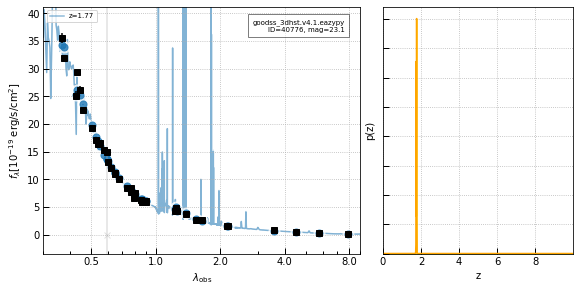

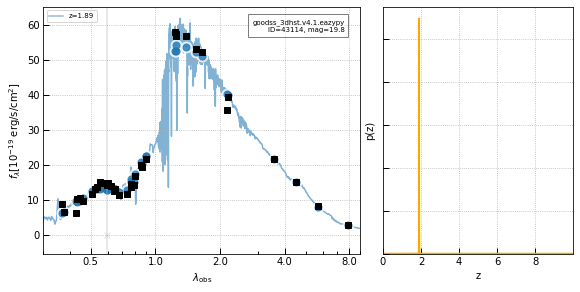

In [11]:
# Show SEDs with best-fit templates and p(z)
for ix in idx3:
    ez.show_fit(ix, id_is_idx=True)

In [12]:
### Spline templates for dummy grism continuum fits
wspline = np.arange(4200, 2.5e4)
Rspline = 50
df_spl = len(utils.log_zgrid(zr=[wspline[0], wspline[-1]], dz=1./Rspline))
tspline = utils.bspline_templates(wspline, df=df_spl+2, log=True, clip=0.0001)

In [13]:
i=1 # red galaxy
id=tab['id'][i]
ix = idx3[i]

In [14]:
## This isn't necessary for general fitting, but 
## load the grism spectrum here for demonstrating the grism/photometry scaling
beams_file = '{0}_{1:05d}.beams.fits'.format(args['group_name'], id)
mb = multifit.MultiBeam(beams_file, MW_EBV=args['MW_EBV'],
                        fcontam=args['fcontam'], sys_err=args['sys_err'],
                        group_name=args['group_name'])

load_master_fits: j033216m2743_00423.beams.fits
1 ib6o23rsq_flt.fits G141
2 ib6o21qmq_flt.fits G102
3 ib6o23ruq_flt.fits G141
4 ib6o21r6q_flt.fits G102
5 ib6o21qoq_flt.fits G102
6 ib6o23ryq_flt.fits G141
7 ib6o21r8q_flt.fits G102
8 ib6o23s0q_flt.fits G141


Pull out the photometry of the nearest source matched in the photometric catalog.

In [15]:
# Generate the `phot` dictionary
phot, ii, dd = phot_obj.get_phot_dict(mb.ra, mb.dec)
label = "3DHST Catalog ID: {0}, dr={1:.2f}, zphot={2:.3f}"
print(label.format(ez.cat['id'][ii], dd, ez.zbest[ii]))

print('\n`phot` keys:', list(phot.keys()))
for k in phot:
    print('\n'+k+':\n', phot[k])
    
# Initialize photometry for the MultiBeam object
mb.set_photometry(**phot)

3DHST Catalog ID: 43114, dr=0.33 arcsec, zphot=1.894

`phot` keys: ['source', 'flam', 'eflam', 'filters', 'tempfilt', 'ext_corr', 'pz', 'z_spec']

source:
 unknown

flam:
 [ 5.30664993e-18  6.50808378e-19  1.01717802e-18 -9.90000000e-18
  1.42317151e-18  1.25620655e-18  1.42979103e-18  1.66921985e-18
  2.16008818e-18  2.14966875e-18  5.65991889e-18  5.79295364e-18
  5.68367506e-18  5.22532120e-18  3.92512737e-18  2.16817930e-18
  1.51142657e-18  8.15954797e-19  2.65264975e-19  8.60178302e-19
  9.64812279e-19  1.34991010e-18  1.31000202e-18  1.94212156e-18
  6.05269519e-19  1.04398042e-18  1.15307426e-18  1.30870485e-18
  1.49600607e-18  1.47046006e-18  1.46291351e-18  1.37704928e-18
  1.28798957e-18  1.11869349e-18  1.15220635e-18  1.36151816e-18
  1.42642964e-18  1.97604148e-18  5.73461780e-18  3.56132974e-18]

eflam:
 [ 5.45818244e-20  1.49454484e-20  2.42378424e-20 -9.90000000e-18
  1.77166399e-20  1.44719664e-20  1.77094396e-20  1.83233972e-20
  2.40258276e-20  3.14316654e-20  5.71

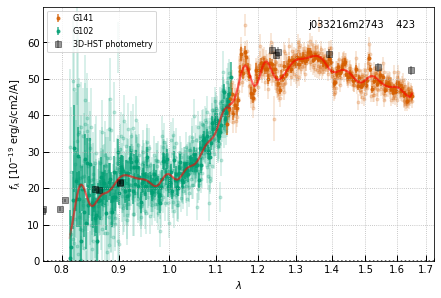

In [16]:
# parametric template fit to get reasonable background
sfit = mb.template_at_z(templates=tspline, fit_background=True, 
                        include_photometry=False)
fig = mb.oned_figure(tfit=sfit)

ax = fig.axes[0]
ax.errorbar(mb.photom_pivot/1.e4, mb.photom_flam/1.e-19, 
            mb.photom_eflam/1.e-19, 
            marker='s', color='k', alpha=0.4, linestyle='None',
            label='3D-HST photometry')

ax.legend(loc='upper left', fontsize=8)

### Scaling the spectrum to the photometry 

For the grism spectra, the total flux of an object is the flux integrated over the segmentation polygon, which corresponds to some isophotal level set by the SExtractor/SEP `threshold parameter`.   While this should often be similar to the total flux definition in the photometric catalog (e.g., FLUX_AUTO), they won't necessarily be the same and there could be small offsets in the normalization between photometry and spectra.

Below we demonstrate a quick way to scale the spectrum to the photometry for more reliable combined fits.

No rescaling, chi-squared=15242.9


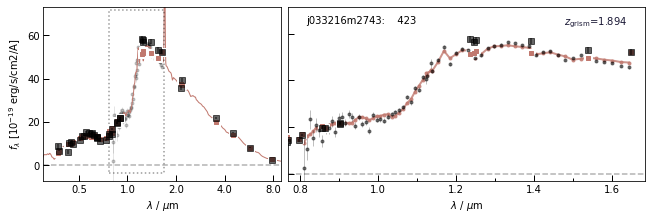

In [17]:
## First example:  no rescaling
z_phot = ez.zbest[ix]

# Reset scale parameter
if hasattr(mb,'pscale'):
    delattr(mb, 'pscale')
    
t1 = args['t1']
tfit = mb.template_at_z(z=z_phot)
print('No rescaling, chi-squared={0:.1f}'.format(tfit['chi2']))
fig = fitting.full_sed_plot(mb, tfit, zfit=None, bin=4)

An small offset is visible betwen the spectra and photometry.  In the next step, we use an internal function to compute a correction factor to bring the spectrum in line with the photometry.  

The `scale_to_photometry` function integrates the *observed* 1D spectrum (combining all available grisms) through the photometry filter bandpasses and derives a polynomial correction to make the two agree.  

**NB** Because we use the observed spectrum directly, `scale_to_photometry` requires that at least one observed filter be *entirely* covered by the grism spectrum.  And fitting for a higher order correction requires multiple filters across the grism bandpass (generally at least one filter per polynomial order).

[9.12869672]
Simple scaling, chi-squared=15255.4


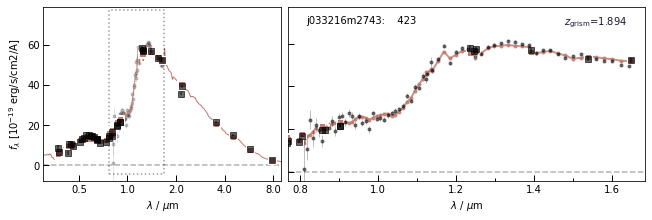

In [18]:
# Reset scale parameter
if hasattr(mb,'pscale'):
    delattr(mb, 'pscale')

# Template rescaling, simple multiplicative factor
scl = mb.scale_to_photometry(order=0)

# has funny units of polynomial coefficients times 10**power, 
# see `grizli.fitting.GroupFitter.compute_scale_array`
# Scale value is the inverse, so, e.g., 
# scl.x = [8.89] means scale the grism spectrum by 10/8.89=1.12
print(scl.x) 

mb.pscale = scl.x 

# Redo template fit
tfit = mb.template_at_z(z=z_phot)
print('Simple scaling, chi-squared={0:.1f}'.format(tfit['chi2']))
fig = fitting.full_sed_plot(mb, tfit, zfit=None, bin=4)

The function computed a multiplicative factor 10/9.5=1.05 to apply to the spectrum, which now falls nicely on top of the photometry.  Next we fit for a first-order linear scaling (normalization and slope).

[ 9.42662873 -1.42901306]
Simple scaling, chi-squared=15218.9


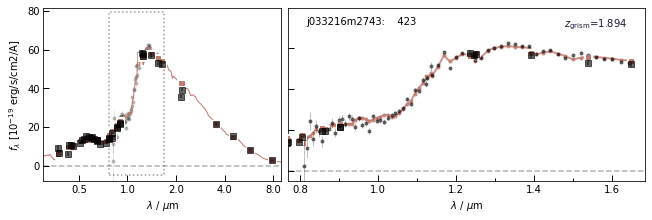

In [19]:
# Reset scale parameter
if hasattr(mb,'pscale'):
    delattr(mb, 'pscale')
    mb.compute_model()

# Template rescaling, linear fit
scl = mb.scale_to_photometry(order=1)

# has funny units of polynomial coefficients times 10**power, 
# see `grizli.fitting.GroupFitter.compute_scale_array`
# Scale value is the inverse, so, e.g., 
# scl.x = [8.89] means scale the grism spectrum by 10/8.89=1.12
print(scl.x) 

mb.pscale = scl.x 

# Redo template fit
tfit = mb.template_at_z(z=z_phot)
print('Simple scaling, chi-squared={0:.1f}'.format(tfit['chi2']))
fig = fitting.full_sed_plot(mb, tfit, zfit=None, bin=4)

A bit of an improvement.  But be careful with corrections with `order>0` if there is limited photometry available in bands *that overlap the spectrum*.

Run id=423 with fit_args.npy
scale_to_photometry: [9.13, -0.96]
j033216m2743_00423.full.fits


(423, 1, 15.387341976165771)

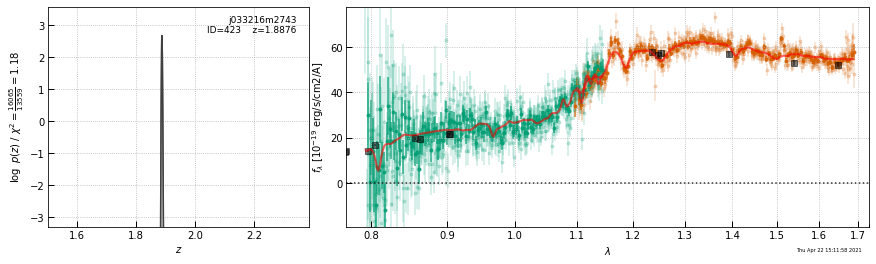

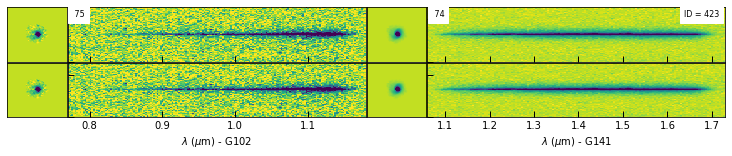

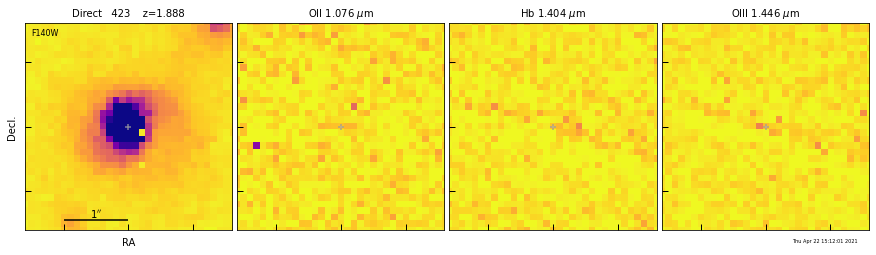

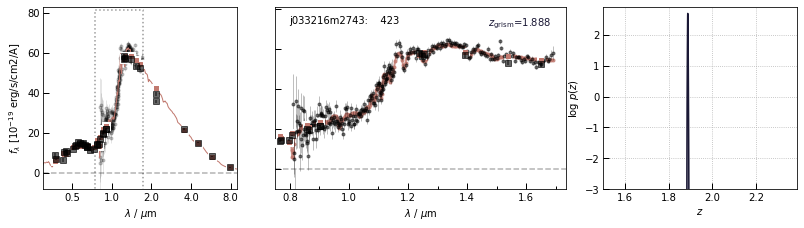

In [29]:
if hasattr(mb,'pscale'):
    delattr(mb, 'pscale')
    mb.compute_model()

# Now run the full redshift fit script with the photometry, which will also do the scaling
order=1
fitting.run_all_parallel(id, phot=phot, verbose=False, 
                         scale_photometry=order+1, zr=[1.5, 2.4])

### Redshift PDF

Now compare the redshift PDF for the grism+photometry and photometry-only (photo-z) fits.

Best redshift: 1.8876


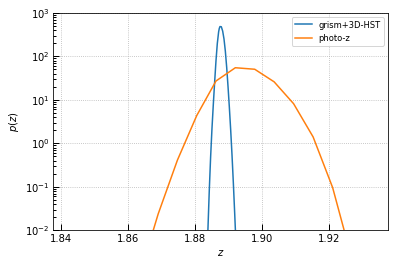

In [30]:
zfit = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id))
z_grism = zfit['ZFIT_STACK'].header['Z_MAP']
print('Best redshift: {0:.4f}'.format(z_grism))

# Compare PDFs
pztab = utils.GTable.gread(zfit['ZFIT_STACK'])
plt.plot(pztab['zgrid'], pztab['pdf'], label='grism+3D-HST')

plt.plot(ez.zgrid, np.exp(ez.lnp[ix,:]), label='photo-z')

plt.semilogy()
plt.xlim(z_grism-0.05, z_grism+0.05); plt.ylim(1.e-2, 1000)
plt.xlabel(r'$z$'); plt.ylabel(r'$p(z)$')
plt.grid()
plt.legend()

### Grizli internal photometry

The archive query functions shown in the `Grizli-Pipeline` notebook can optionally query for *any* HST imaging that overlaps with the grism exposures.  The automatic preparation script will process and align these along with the grism+direct data and produce a simple forced-aperture photometric catalog.  Currently this catalog just has matched aperture photometry and does not make any effort at PSF matching.  

For cases where no external photometric catalog is available, this photometry can be used to help constrain the redshift fits.  The catalog and `eazy-py` products are automatically generated by the preparation scripts.

The `grizli.pipeline.photoz` scripts can also try to fetch additional photometry from published Vizier catalogs, e.g., GALEX, SDSS, PanSTARRS, WISE, CFHT-LS.

In [31]:
import grizli.pipeline.photoz
# The catalog is automatically generated with a number of aperture sizes.  A total 
# correction is computed in the detection band, usually a weighted sum of all available 
# WFC3/IR filters, with the correction as the ratio between the aperture flux and the 
# flux over the isophotal segment region, the 'flux' column in the SEP catalog.
aper_ix = 1
total_flux_column = 'flux'

# Get external photometry from Vizier
get_external_photometry = False #True

# Set `object_only=True` to generate the `eazy.photoz.Photoz` object from the 
# internal photometric catalog without actually running the photo-zs on the catalog 
# with few bands.   
int_ez = grizli.pipeline.photoz.eazy_photoz(root, force=False, object_only=True, 
                  apply_background=True, aper_ix=aper_ix, 
                  apply_prior=True, beta_prior=True, 
                  get_external_photometry=get_external_photometry, 
                  external_limits=3, external_sys_err=0.3, external_timeout=300, 
                  sys_err=0.05, z_step=0.01, z_min=0.01, z_max=12, 
                  total_flux=total_flux_column)

Apply catalog corrections
Read default param file: /Users/gbrammer/miniconda3/envs/grizli37/lib/python3.7/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: j033216m2743_phot_apcorr.fits
   >>> NOBJ = 714
f098m_tot_1 f098m_etot_1 (201): hst/wfc3/IR/f098m.dat
f140w_tot_1 f140w_etot_1 (204): hst/wfc3/IR/f140w.dat
Read PRIOR_FILE:  templates/prior_F160W_TAO.dat
Template grid: templates/fsps_full/tweak_fsps_QSF_12_v3.param (this may take some time)
Process template tweak_fsps_QSF_12_v3_001.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_002.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_003.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_004.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_005.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_006.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_007.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_008.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_009.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_010.dat (NZ=1).

In [32]:
# Available apertures
for k in int_ez.cat.meta:
    if k.startswith('APER'):
        print('Aperture {0}: R={1:>4.1f} pix = {2:>4.2f}"'.format(k, int_ez.cat.meta[k], 
                                                                 int_ez.cat.meta[k]*0.06))

k = 'APER_{0}'.format(aper_ix)
print('\nAperture used {0}: R={1:>4.1f} pix = {2:>4.2f}"'.format(k, int_ez.cat.meta[k], 
                                                                 int_ez.cat.meta[k]*0.06))

Aperture APERMASK: R= 1.0 pix = 0.06"
Aperture APER_0: R= 6.0 pix = 0.36"
Aperture APER_1: R= 8.3 pix = 0.50"
Aperture APER_2: R=11.7 pix = 0.70"
Aperture APER_3: R=16.7 pix = 1.00"
Aperture APER_4: R=20.0 pix = 1.20"
Aperture APER_5: R=25.0 pix = 1.50"
Aperture APER_6: R=50.0 pix = 3.00"

Aperture used APER_1: R= 8.3 pix = 0.50"


In [33]:
# Integrate the grism templates through the filters on the redshift grid. 
int_phot_obj = photoz.EazyPhot(int_ez, grizli_templates=t0, zgrid=int_ez.zgrid)

Process template fsps/fsps_QSF_12_v3_nolines_001.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_002.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_003.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_004.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_005.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_006.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_007.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_008.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_009.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_010.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_011.dat (NZ=1).
Process template fsps/fsps_QSF_12_v3_nolines_012.dat (NZ=1).
Process template alf_SSP.dat (NZ=1).
Process template line Ha+NII+SII+SIII+He+PaB (NZ=1).
Process template line OIII+Hb+Hg+Hd (NZ=1).
Process template line OII+Ne (NZ=1).
Process template line Gal-UV-lines (NZ=1).


No rescaling, chi-squared=14970.0


(-5.0, 80.0)

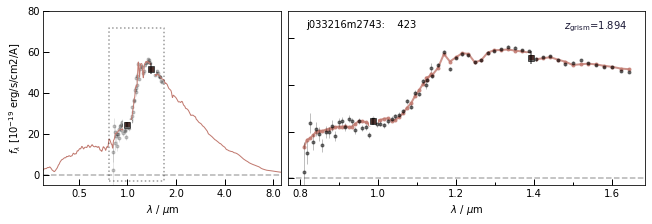

In [34]:
# Reset scale parameter
if hasattr(mb,'pscale'):
    delattr(mb, 'pscale')

# Show the SED
int_phot, ii, dd = int_phot_obj.get_phot_dict(mb.ra, mb.dec)

mb.unset_photometry()
mb.set_photometry(**int_phot)

tfit = mb.template_at_z(z=z_phot)
print('No rescaling, chi-squared={0:.1f}'.format(tfit['chi2']))
fig = fitting.full_sed_plot(mb, tfit, zfit=None, bin=4)
fig.axes[0].set_ylim(-5,80)

Run id=423 with fit_args.npy
scale_to_photometry: [9.88]
j033216m2743_00423.full.fits


(423, 1, 15.220025062561035)

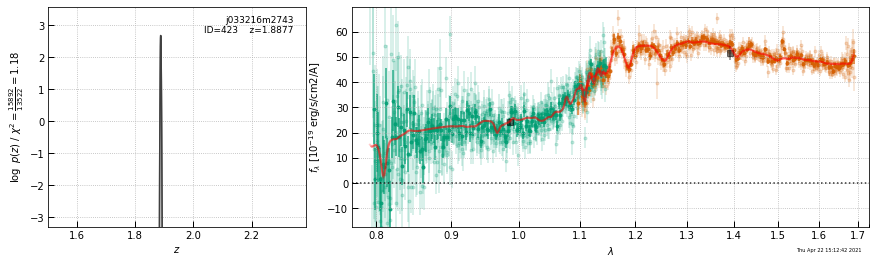

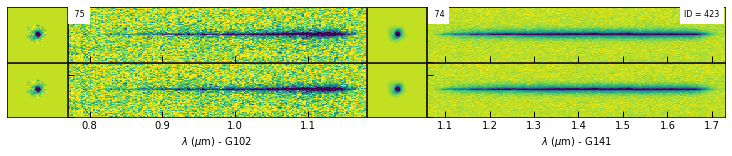

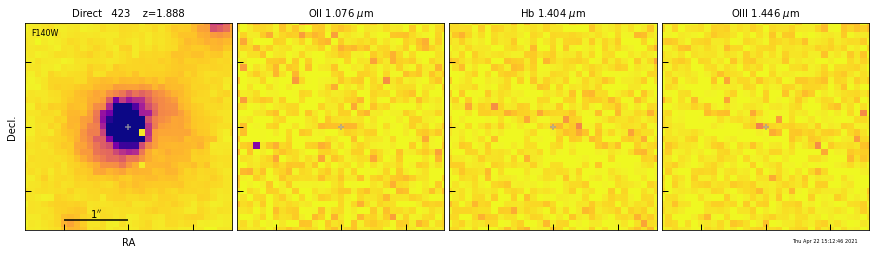

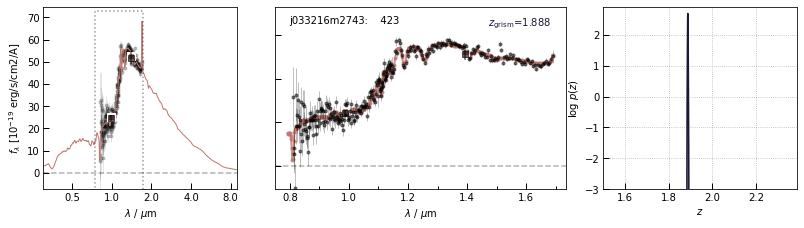

In [35]:
# Run the grism fit with the direct image photometry

# Note that here we show that you can just pass the full photometry object 
# and the script will match the nearest photometric entry to the grism object.
order=0
fitting.run_all_parallel(id, phot_obj=int_phot_obj, verbose=False, use_phot_obj=True, 
                         scale_photometry=order+1, zr=[1.5, 2.4])

### Compare chi-squared

In this case of this bright spectrum with strong features, the grism dominates the fit even with the extensive 3D-HST catalog

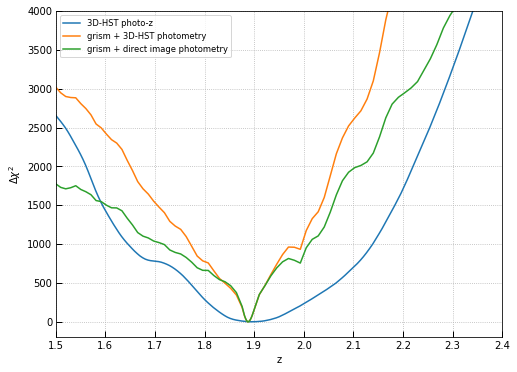

In [36]:
zfit2 = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id))
pztab2 = utils.GTable.gread(zfit2['ZFIT_STACK'])

fig, ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(ez.zgrid, ez.chi2_fit[ix,:] - ez.chi2_fit[ix,:].min(), 
         label='3D-HST photo-z')

ax.plot(pztab['zgrid'],  pztab['chi2'] - pztab['chi2'].min(), 
         label='grism + 3D-HST photometry')

ax.plot(pztab2['zgrid'], pztab2['chi2'] - pztab2['chi2'].min(), 
         label='grism + direct image photometry')

ax.legend()
ax.set_xlabel('z')
ax.set_ylabel(r'$\Delta \chi^2$')
ax.set_xlim(1.5, 2.4)
ax.set_ylim(-200, 4000)
ax.grid()